In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import riiideducation

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

env = riiideducation.make_env()
iter_test = env.iter_test()

# Data

In [3]:
train = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/train.csv',
                   usecols=[1, 2, 3, 4, 7, 8, 9],
                   dtype={'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'},
                    nrows=10**6)

train = train[train.content_type_id == False]
train = train.sort_values(['timestamp'], ascending=True).reset_index(drop = True)

print(train.shape)
train.head()

(980093, 7)


,timestamp,user_id,content_id,content_type_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,NaN,<NA>
1,0,19437777,7900,0,1,NaN,<NA>
2,0,15244238,4356,0,1,NaN,<NA>
3,0,15240250,7900,0,0,NaN,<NA>
4,0,786789,7900,0,1,NaN,<NA>


In [4]:
results_c_final = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c_final.columns = ["answered_correctly_content"]

print(results_c_final.shape)
results_c_final.head()

(13076, 1)


,answered_correctly_content
content_id,
0,0.863014
1,0.927273
2,0.560811
3,0.798995
4,0.602606


In [5]:
results_u_final = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum', 'count'])
results_u_final.columns = ['answered_correctly_user', 'sum', 'count']

print(results_u_final.shape)
results_u_final.head()

(3824, 3)


,answered_correctly_user,sum,count
user_id,,,
115,0.695652,32.0,46
124,0.233333,7.0,30
2746,0.578947,11.0,19
5382,0.672000,84.0,125
8623,0.642202,70.0,109


In [6]:
elapsed_mean = train.prior_question_elapsed_time.mean()

print(elapsed_mean)

25321.21875


In [7]:
print(train.loc[(train.timestamp == 0)].answered_correctly.mean())
print(train.loc[(train.timestamp != 0)].answered_correctly.mean())
print(train.loc[(train.timestamp < 1000000) & (train.timestamp > 0)].answered_correctly.mean())
print(train.prior_question_had_explanation.value_counts())
print(train.answered_correctly.mean())

0.6794905120873408
0.650242869112908
0.4720422649528504
True     889887
False     86390
Name: prior_question_had_explanation, dtype: Int64
0.6503576701394663


In [8]:
train.drop(['timestamp', 'content_type_id'], axis=1, inplace=True)

print(train.shape)
train.head()

(980093, 5)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,1,NaN,<NA>
1,19437777,7900,1,NaN,<NA>
2,15244238,4356,1,NaN,<NA>
3,15240250,7900,0,NaN,<NA>
4,786789,7900,1,NaN,<NA>


In [9]:
validation = pd.DataFrame()

for i in range(4):
    last_records = train.drop_duplicates('user_id', keep = 'last')
    train = train[~train.index.isin(last_records.index)]
    validation = validation.append(last_records)
    
print(len(train))
print(len(validation))

print(validation.answered_correctly.mean())
print(train.answered_correctly.mean())

964808
15285
0.5362119725220804
0.652166026815698


In [10]:
X = pd.DataFrame()

for i in range(15):
    last_records = train.drop_duplicates('user_id', keep = 'last')
    train = train[~train.index.isin(last_records.index)]
    X = X.append(last_records)
    
print(len(X))
print(len(train))

print(X.answered_correctly.mean())
print(train.answered_correctly.mean())

55271
909537
0.5550469504803605
0.6580677861373424


In [11]:
results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content"]

print(results_c.shape)
results_c.head()

(13061, 1)


,answered_correctly_content
content_id,
0,0.897059
1,0.924528
2,0.558252
3,0.795812
4,0.609665


In [12]:
results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum', 'count'])
results_u.columns = ["answered_correctly_user", 'sum', 'count']

print(results_u.shape)
results_u.head()

(3276, 3)


,answered_correctly_user,sum,count
user_id,,,
115,0.703704,19.0,27
124,0.363636,4.0,11
5382,0.669811,71.0,106
8623,0.611111,55.0,90
12741,0.556911,137.0,246


In [13]:
del(train)

# Dataset (X, validation)

In [14]:
X = pd.merge(X, results_u, on=['user_id'], how="left")
X = pd.merge(X, results_c_final, on=['content_id'], how="left")

print(X.shape)
X.head()

(55271, 9)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content
0,8343734,4439,1,17000.0,False,NaN,NaN,NaN,0.203252
1,11814782,9117,0,1000.0,False,NaN,NaN,NaN,0.720000
2,3258925,8894,1,1000.0,False,NaN,NaN,NaN,0.355556
3,1360462,88,0,9000.0,False,NaN,NaN,NaN,0.607143
4,15786147,6477,0,19000.0,False,NaN,NaN,NaN,0.293233


In [15]:
validation = pd.merge(validation, results_u, on=['user_id'], how="left")
validation = pd.merge(validation, results_c_final, on=['content_id'], how="left")

print(validation.shape)
validation.head()

(15285, 9)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content
0,19887248,6368,0,NaN,<NA>,NaN,NaN,NaN,0.744186
1,1880240,192,1,NaN,<NA>,NaN,NaN,NaN,0.969697
2,2148001,9320,0,21000.0,False,NaN,NaN,NaN,0.758621
3,15960740,7924,0,77000.0,False,NaN,NaN,NaN,0.748571
4,1946295,175,1,20000.0,False,NaN,NaN,NaN,0.359084


In [16]:
lb_make = LabelEncoder()

X.prior_question_had_explanation.fillna(False, inplace = True)
validation.prior_question_had_explanation.fillna(False, inplace = True)

X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])
validation["prior_question_had_explanation_enc"] = lb_make.fit_transform(validation["prior_question_had_explanation"])

In [17]:
print(X.shape)
X.head()

(55271, 10)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc
0,8343734,4439,1,17000.0,False,NaN,NaN,NaN,0.203252,0
1,11814782,9117,0,1000.0,False,NaN,NaN,NaN,0.720000,0
2,3258925,8894,1,1000.0,False,NaN,NaN,NaN,0.355556,0
3,1360462,88,0,9000.0,False,NaN,NaN,NaN,0.607143,0
4,15786147,6477,0,19000.0,False,NaN,NaN,NaN,0.293233,0


In [18]:
print(validation.shape)
validation.head()

(15285, 10)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc
0,19887248,6368,0,NaN,False,NaN,NaN,NaN,0.744186,0
1,1880240,192,1,NaN,False,NaN,NaN,NaN,0.969697,0
2,2148001,9320,0,21000.0,False,NaN,NaN,NaN,0.758621,0
3,15960740,7924,0,77000.0,False,NaN,NaN,NaN,0.748571,0
4,1946295,175,1,20000.0,False,NaN,NaN,NaN,0.359084,0


In [19]:
questions_df = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv',
                            usecols=[0, 3],
                            dtype={'question_id': 'int16',
                              'part': 'int8'})

print(questions_df.shape)
questions_df.head()

(13523, 2)


,question_id,part
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [20]:
X = pd.merge(X, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')
validation = pd.merge(validation, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

X.part = X.part - 1
validation.part = validation.part - 1

print(X.part.value_counts())
print(validation.part.value_counts())

4    27885
1    11807
5     4898
3     4410
0     2906
6     1734
2     1631
Name: part, dtype: int64
4    7480
1    3234
6    2546
0     671
5     589
3     462
2     303
Name: part, dtype: int64


In [21]:
print(X.shape)
X.head()

(55271, 12)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc,question_id,part
0,8343734,4439,1,17000.0,False,NaN,NaN,NaN,0.203252,0,4439,4
1,11814782,9117,0,1000.0,False,NaN,NaN,NaN,0.720000,0,9117,4
2,3258925,8894,1,1000.0,False,NaN,NaN,NaN,0.355556,0,8894,4
3,1360462,88,0,9000.0,False,NaN,NaN,NaN,0.607143,0,88,0
4,15786147,6477,0,19000.0,False,NaN,NaN,NaN,0.293233,0,6477,4


In [22]:
print(validation.shape)
validation.head()

(15285, 12)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly_user,sum,count,answered_correctly_content,prior_question_had_explanation_enc,question_id,part
0,19887248,6368,0,NaN,False,NaN,NaN,NaN,0.744186,0,6368,4
1,1880240,192,1,NaN,False,NaN,NaN,NaN,0.969697,0,192,0
2,2148001,9320,0,21000.0,False,NaN,NaN,NaN,0.758621,0,9320,4
3,15960740,7924,0,77000.0,False,NaN,NaN,NaN,0.748571,0,7924,0
4,1946295,175,1,20000.0,False,NaN,NaN,NaN,0.359084,0,175,0


In [23]:
y = X['answered_correctly']
X = X.drop(['answered_correctly'], axis=1)

y_val = validation['answered_correctly']
X_val = validation.drop(['answered_correctly'], axis=1)

In [24]:
X = X[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']]

X_val = X_val[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']]

In [25]:
X['answered_correctly_user'].fillna(0.5,  inplace=True)
X['answered_correctly_content'].fillna(0.5,  inplace=True)
X['part'].fillna(4, inplace = True)
X['sum'].fillna(0, inplace = True)
X['count'].fillna(0, inplace = True)
X['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X['prior_question_had_explanation_enc'].fillna(0, inplace = True)

X_val['answered_correctly_user'].fillna(0.5,  inplace=True)
X_val['answered_correctly_content'].fillna(0.5,  inplace=True)
X_val['part'].fillna(4, inplace = True)
X_val['count'].fillna(0, inplace = True)
X_val['sum'].fillna(0, inplace = True)
X_val['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X_val['prior_question_had_explanation_enc'].fillna(0, inplace = True)

# Modeling

In [26]:
import lightgbm as lgb

params = {
    'objective': 'binary',
    'max_bin': 700,
    'learning_rate': 0.0175,
    'num_leaves': 80
}

lgb_train = lgb.Dataset(X, y, categorical_feature = ['part', 'prior_question_had_explanation_enc'])
lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature = ['part', 'prior_question_had_explanation_enc'], reference=lgb_train)

In [27]:
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=12
)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 12 rounds
[50]	training's binary_logloss: 0.603899	valid_1's binary_logloss: 0.627715
[100]	training's binary_logloss: 0.58143	valid_1's binary_logloss: 0.61543
[150]	training's binary_logloss: 0.571657	valid_1's binary_logloss: 0.612741
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.567679	valid_1's binary_logloss: 0.612406


In [28]:
y_pred = model.predict(X_val)
y_true = np.array(y_val)
roc_auc_score(y_true, y_pred)

0.721275713904804

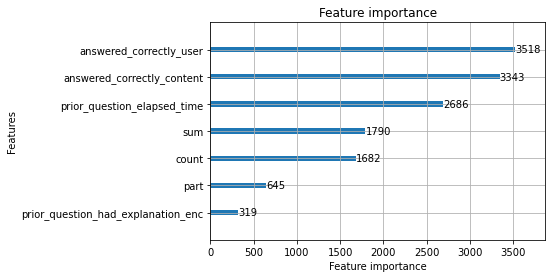

In [29]:
lgb.plot_importance(model)
plt.show()

# Submit

In [30]:
for (test_df, sample_prediction_df) in iter_test:
    
    test_df = pd.merge(test_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')
    test_df = pd.merge(test_df, results_u_final, on=['user_id'],  how="left")
    test_df = pd.merge(test_df, results_c_final, on=['content_id'],  how="left")
    test_df['answered_correctly_user'].fillna(0.5,  inplace=True)
    test_df['answered_correctly_content'].fillna(0.5,  inplace=True)
    test_df['part'] = test_df.part - 1
    test_df['part'].fillna(4, inplace = True)
    test_df['sum'].fillna(0, inplace=True)
    test_df['count'].fillna(0, inplace=True)
    test_df['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
    test_df['answered_correctly'] =  model.predict(test_df[['answered_correctly_user', 'answered_correctly_content', 'sum', 'count',
                                                            'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part']])
    
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])